In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import obonet
import networkx as nx
from collections import Counter, defaultdict

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Paths
DATA_DIR = '/home/hoangtungvum/Data/ML_UET/CAFA-6-Protein-Function-Prediction-Kaggle/data'
TRAIN_DIR = f'{DATA_DIR}/Train'
FIGURES_DIR = '/home/hoangtungvum/Data/ML_UET/CAFA-6-Protein-Function-Prediction-Kaggle/figures'

print('✅ Libraries imported successfully!')

✅ Libraries imported successfully!


## 1. Load GO Graph

In [2]:
# Load GO graph from OBO file
print('Loading GO graph from go-basic.obo...')
go_graph = obonet.read_obo(f'{TRAIN_DIR}/go-basic.obo')

print(f'\n📊 GO GRAPH OVERVIEW')
print('=' * 60)
print(f'  Total nodes (GO terms): {go_graph.number_of_nodes():,}')
print(f'  Total edges (relationships): {go_graph.number_of_edges():,}')
print(f'  Graph type: {type(go_graph).__name__}')
print(f'  Is directed: {go_graph.is_directed()}')
print(f'  Is multigraph: {go_graph.is_multigraph()}')

Loading GO graph from go-basic.obo...

📊 GO GRAPH OVERVIEW
  Total nodes (GO terms): 40,122
  Total edges (relationships): 77,229
  Graph type: MultiDiGraph
  Is directed: True
  Is multigraph: True

📊 GO GRAPH OVERVIEW
  Total nodes (GO terms): 40,122
  Total edges (relationships): 77,229
  Graph type: MultiDiGraph
  Is directed: True
  Is multigraph: True


## 2. Node Structure Analysis

In [3]:
# Examine node structure
print('🔍 NODE STRUCTURE ANALYSIS')
print('=' * 60)

# Get a sample node
sample_node = 'GO:0000001'
node_data = go_graph.nodes[sample_node]

print(f'\nSample node: {sample_node}')
print(f'Node attributes:')
for key, value in node_data.items():
    if isinstance(value, str) and len(value) > 100:
        print(f'  {key}: {value[:100]}...')
    else:
        print(f'  {key}: {value}')

🔍 NODE STRUCTURE ANALYSIS

Sample node: GO:0000001
Node attributes:
  name: mitochondrion inheritance
  namespace: biological_process
  def: "The distribution of mitochondria, including the mitochondrial genome, into daughter cells after mit...
  synonym: ['"mitochondrial inheritance" EXACT []']
  is_a: ['GO:0048308', 'GO:0048311']


In [4]:
# Analyze all node attributes
print('📋 ALL NODE ATTRIBUTES IN GO GRAPH')
print('=' * 60)

all_attributes = set()
for node in go_graph.nodes():
    all_attributes.update(go_graph.nodes[node].keys())

print(f'\nUnique node attributes: {len(all_attributes)}')
for attr in sorted(all_attributes):
    # Count how many nodes have this attribute
    count = sum(1 for n in go_graph.nodes() if attr in go_graph.nodes[n])
    print(f'  • {attr}: {count:,} nodes ({100*count/go_graph.number_of_nodes():.1f}%)')

📋 ALL NODE ATTRIBUTES IN GO GRAPH

Unique node attributes: 10
  • alt_id: 2,204 nodes (5.5%)
  • comment: 2,314 nodes (5.8%)
  • def: 40,122 nodes (100.0%)


Unique node attributes: 10
  • alt_id: 2,204 nodes (5.5%)
  • comment: 2,314 nodes (5.8%)
  • def: 40,122 nodes (100.0%)
  • is_a: 40,119 nodes (100.0%)
  • name: 40,122 nodes (100.0%)
  • namespace: 40,122 nodes (100.0%)
  • relationship: 14,340 nodes (35.7%)
  • subset: 2,236 nodes (5.6%)
  • synonym: 26,738 nodes (66.6%)
  • xref: 8,335 nodes (20.8%)
  • is_a: 40,119 nodes (100.0%)
  • name: 40,122 nodes (100.0%)
  • namespace: 40,122 nodes (100.0%)
  • relationship: 14,340 nodes (35.7%)
  • subset: 2,236 nodes (5.6%)
  • synonym: 26,738 nodes (66.6%)
  • xref: 8,335 nodes (20.8%)


In [5]:
# Analyze namespaces (subontologies)
print('🏷️ NAMESPACE (SUBONTOLOGY) DISTRIBUTION')
print('=' * 60)

namespaces = Counter()
for node in go_graph.nodes():
    ns = go_graph.nodes[node].get('namespace', 'unknown')
    namespaces[ns] += 1

print(f'\n{"Namespace":<30} {"Count":>10} {"Percentage":>12}')
print('-' * 55)
for ns, count in namespaces.most_common():
    pct = 100 * count / go_graph.number_of_nodes()
    print(f'{ns:<30} {count:>10,} {pct:>11.1f}%')

🏷️ NAMESPACE (SUBONTOLOGY) DISTRIBUTION

Namespace                           Count   Percentage
-------------------------------------------------------
biological_process                 25,950        64.7%
molecular_function                 10,131        25.3%
cellular_component                  4,041        10.1%


## 3. Edge Structure Analysis

In [6]:
# Analyze edge types (relationship types)
print('🔗 EDGE RELATIONSHIP TYPES')
print('=' * 60)

edge_types = Counter()
for u, v, key in go_graph.edges(keys=True):
    edge_types[key] += 1

print(f'\n{"Relationship Type":<30} {"Count":>10} {"Percentage":>12}')
print('-' * 55)
total_edges = go_graph.number_of_edges()
for rel, count in edge_types.most_common():
    pct = 100 * count / total_edges
    print(f'{rel:<30} {count:>10,} {pct:>11.1f}%')

🔗 EDGE RELATIONSHIP TYPES

Relationship Type                   Count   Percentage
-------------------------------------------------------
is_a                               62,410        80.8%
part_of                             6,597         8.5%
regulates                           2,989         3.9%
positively_regulates                2,619         3.4%
negatively_regulates                2,614         3.4%
is_a                               62,410        80.8%
part_of                             6,597         8.5%
regulates                           2,989         3.9%
positively_regulates                2,619         3.4%
negatively_regulates                2,614         3.4%


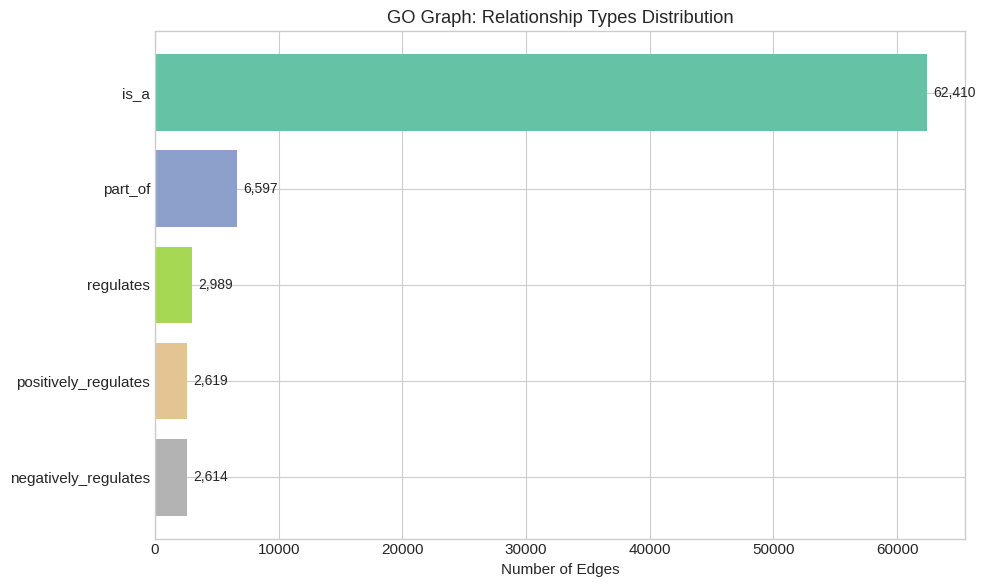

In [7]:
# Visualize edge types
fig, ax = plt.subplots(figsize=(10, 6))

rel_names = [r for r, _ in edge_types.most_common()]
rel_counts = [c for _, c in edge_types.most_common()]
colors = plt.cm.Set2(np.linspace(0, 1, len(rel_names)))

bars = ax.barh(rel_names, rel_counts, color=colors)
ax.set_xlabel('Number of Edges')
ax.set_title('GO Graph: Relationship Types Distribution')
ax.invert_yaxis()

for bar, count in zip(bars, rel_counts):
    ax.text(bar.get_width() + 500, bar.get_y() + bar.get_height()/2,
            f'{count:,}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/go_graph_edge_types.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Root Nodes (Depth 0) Analysis

In [8]:
# Find root nodes (nodes with no outgoing is_a edges = top of hierarchy)
print('🌳 ROOT NODES (DEPTH 0) ANALYSIS')
print('=' * 60)

# The 3 main root nodes
root_nodes = {
    'GO:0008150': 'biological_process',
    'GO:0005575': 'cellular_component',
    'GO:0003674': 'molecular_function'
}

print('\n📌 THE 3 MAIN ROOT NODES:')
print('-' * 60)

for go_id, ns in root_nodes.items():
    if go_id in go_graph.nodes:
        node = go_graph.nodes[go_id]
        name = node.get('name', 'N/A')
        definition = node.get('def', 'N/A')
        
        # Count children (nodes that have is_a edge to this root)
        children = list(go_graph.predecessors(go_id))
        
        print(f'\n🔹 {go_id}')
        print(f'   Name: {name}')
        print(f'   Namespace: {ns}')
        print(f'   Direct children: {len(children):,}')
        if definition:
            def_text = definition[:150] + '...' if len(definition) > 150 else definition
            print(f'   Definition: {def_text}')

🌳 ROOT NODES (DEPTH 0) ANALYSIS

📌 THE 3 MAIN ROOT NODES:
------------------------------------------------------------

🔹 GO:0008150
   Name: biological_process
   Namespace: biological_process
   Direct children: 21
   Definition: "A biological process is the execution of a genetically-encoded biological module or program. It consists of all the steps required to achieve the spe...

🔹 GO:0005575
   Name: cellular_component
   Namespace: cellular_component
   Direct children: 3
   Definition: "A location, relative to cellular compartments and structures, occupied by a macromolecular machine. There are three types of cellular components desc...

🔹 GO:0003674
   Name: molecular_function
   Namespace: molecular_function
   Direct children: 32
   Definition: "A molecular process that can be carried out by the action of a single macromolecular machine, usually via direct physical interactions with other mol...


In [9]:
# Calculate depth for all nodes
print('📊 CALCULATING DEPTHS FOR ALL NODES...')
print('=' * 60)

term_depths = {}
term_namespace = {}

for root_id, ns in root_nodes.items():
    if root_id in go_graph:
        # Depth 0 for root
        term_depths[root_id] = 0
        term_namespace[root_id] = ns
        
        # BFS to find depths
        for node in nx.bfs_tree(go_graph, root_id, reverse=True):
            try:
                depth = nx.shortest_path_length(go_graph, source=node, target=root_id)
                if node not in term_depths or depth < term_depths[node]:
                    term_depths[node] = depth
                    term_namespace[node] = ns
            except:
                pass

print(f'Calculated depth for {len(term_depths):,} nodes')
print(f'Max depth: {max(term_depths.values())}')

# Depth distribution
depth_counts = Counter(term_depths.values())
print(f'\n{"Depth":<10} {"Count":>10} {"Percentage":>12}')
print('-' * 35)
for depth in sorted(depth_counts.keys()):
    count = depth_counts[depth]
    pct = 100 * count / len(term_depths)
    print(f'{depth:<10} {count:>10,} {pct:>11.1f}%')

📊 CALCULATING DEPTHS FOR ALL NODES...
Calculated depth for 40,122 nodes
Max depth: 11

Depth           Count   Percentage
-----------------------------------
0                   3         0.0%
1                  56         0.1%
2               1,329         3.3%
3               5,214        13.0%
4               9,818        24.5%
5              12,563        31.3%
6               6,651        16.6%
7               3,084         7.7%
8               1,067         2.7%
9                 246         0.6%
10                 71         0.2%
11                 20         0.0%
Calculated depth for 40,122 nodes
Max depth: 11

Depth           Count   Percentage
-----------------------------------
0                   3         0.0%
1                  56         0.1%
2               1,329         3.3%
3               5,214        13.0%
4               9,818        24.5%
5              12,563        31.3%
6               6,651        16.6%
7               3,084         7.7%
8               1,067 

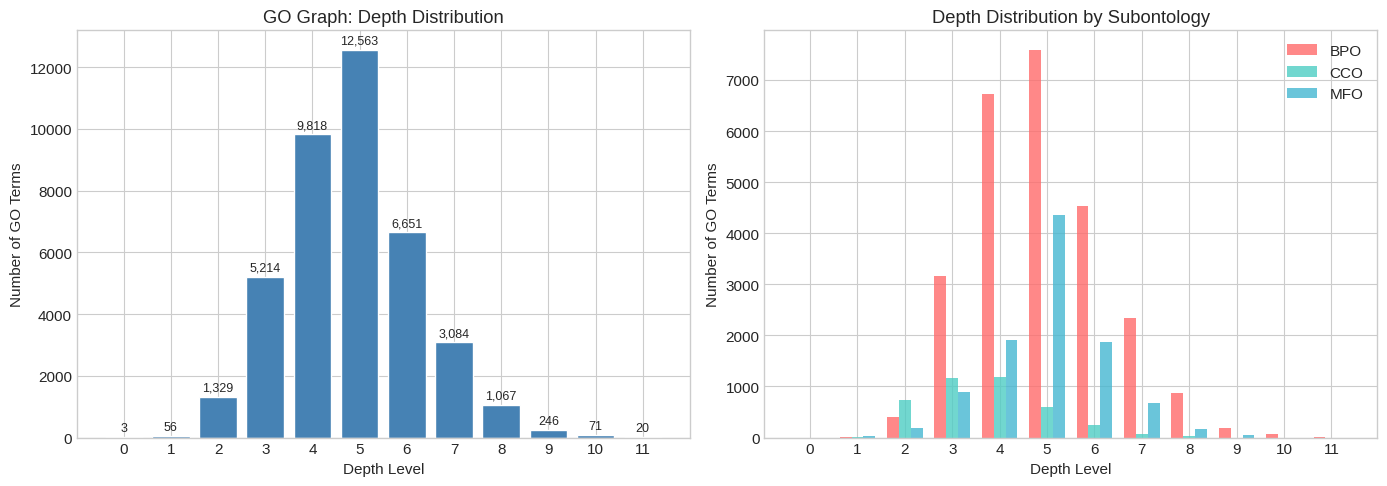

In [10]:
# Visualize depth distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall depth distribution
depths = sorted(depth_counts.keys())
counts = [depth_counts[d] for d in depths]

axes[0].bar(depths, counts, color='steelblue', edgecolor='white')
axes[0].set_xlabel('Depth Level')
axes[0].set_ylabel('Number of GO Terms')
axes[0].set_title('GO Graph: Depth Distribution')
axes[0].set_xticks(depths)

# Add count labels
for d, c in zip(depths, counts):
    axes[0].text(d, c + 200, f'{c:,}', ha='center', fontsize=9)

# Depth by namespace
ns_depth_data = defaultdict(lambda: defaultdict(int))
for node, depth in term_depths.items():
    ns = term_namespace.get(node, 'unknown')
    ns_depth_data[ns][depth] += 1

ns_colors = {
    'biological_process': '#FF6B6B',
    'cellular_component': '#4ECDC4',
    'molecular_function': '#45B7D1'
}

x = np.arange(max(depths) + 1)
width = 0.25

for i, (ns, ns_name) in enumerate([('biological_process', 'BPO'), 
                                    ('cellular_component', 'CCO'),
                                    ('molecular_function', 'MFO')]):
    counts_ns = [ns_depth_data[ns].get(d, 0) for d in range(max(depths) + 1)]
    axes[1].bar(x + i*width, counts_ns, width, label=ns_name, color=ns_colors[ns], alpha=0.8)

axes[1].set_xlabel('Depth Level')
axes[1].set_ylabel('Number of GO Terms')
axes[1].set_title('Depth Distribution by Subontology')
axes[1].set_xticks(x + width)
axes[1].set_xticklabels(range(max(depths) + 1))
axes[1].legend()

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/go_graph_depth_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Examples at Each Depth Level

In [11]:
# Show examples at each depth
print('📋 EXAMPLES OF GO TERMS AT EACH DEPTH LEVEL')
print('=' * 80)

# Group nodes by depth
nodes_by_depth = defaultdict(list)
for node, depth in term_depths.items():
    nodes_by_depth[depth].append(node)

# Show examples for each depth
for depth in sorted(nodes_by_depth.keys()):
    nodes = nodes_by_depth[depth]
    print(f'\n🔹 DEPTH {depth} ({len(nodes):,} terms)')
    print('-' * 80)
    
    # Show up to 5 examples
    for node in nodes[:5]:
        name = go_graph.nodes[node].get('name', 'N/A')
        ns = go_graph.nodes[node].get('namespace', 'N/A')
        
        # Get parents (successors in the graph)
        parents = []
        for _, parent, key in go_graph.out_edges(node, keys=True):
            if key == 'is_a':
                parent_name = go_graph.nodes[parent].get('name', parent)
                parents.append(f'{parent} ({parent_name})')
        
        print(f'  {node}: {name}')
        print(f'    Namespace: {ns}')
        if parents:
            print(f'    Parents (is_a): {", ".join(parents[:2])}{"..." if len(parents) > 2 else ""}')
        print()

📋 EXAMPLES OF GO TERMS AT EACH DEPTH LEVEL

🔹 DEPTH 0 (3 terms)
--------------------------------------------------------------------------------
  GO:0008150: biological_process
    Namespace: biological_process

  GO:0005575: cellular_component
    Namespace: cellular_component

  GO:0003674: molecular_function
    Namespace: molecular_function


🔹 DEPTH 1 (56 terms)
--------------------------------------------------------------------------------
  GO:0002376: immune system process
    Namespace: biological_process
    Parents (is_a): GO:0008150 (biological_process)

  GO:0009987: cellular process
    Namespace: biological_process
    Parents (is_a): GO:0008150 (biological_process)

  GO:0016032: viral process
    Namespace: biological_process
    Parents (is_a): GO:0008150 (biological_process)

  GO:0022414: reproductive process
    Namespace: biological_process
    Parents (is_a): GO:0008150 (biological_process)

  GO:0032501: multicellular organismal process
    Namespace: biologic

## 6. Detailed Depth Analysis by Subontology

In [12]:
# Detailed analysis for each subontology
print('📊 DETAILED DEPTH ANALYSIS BY SUBONTOLOGY')
print('=' * 80)

for ns, ns_abbr in [('biological_process', 'BPO'), 
                     ('cellular_component', 'CCO'),
                     ('molecular_function', 'MFO')]:
    
    # Get nodes for this namespace
    ns_nodes = [n for n, d in term_depths.items() if term_namespace.get(n) == ns]
    ns_depths = [term_depths[n] for n in ns_nodes]
    
    print(f'\n🏷️ {ns_abbr} - {ns.replace("_", " ").title()}')
    print('-' * 60)
    print(f'  Total terms: {len(ns_nodes):,}')
    print(f'  Max depth: {max(ns_depths)}')
    print(f'  Mean depth: {np.mean(ns_depths):.2f}')
    print(f'  Median depth: {np.median(ns_depths):.1f}')
    
    # Depth distribution for this namespace
    ns_depth_counts = Counter(ns_depths)
    print(f'\n  Depth distribution:')
    for depth in sorted(ns_depth_counts.keys()):
        count = ns_depth_counts[depth]
        pct = 100 * count / len(ns_nodes)
        bar = '█' * int(pct / 2)
        print(f'    Depth {depth:2d}: {count:>6,} ({pct:>5.1f}%) {bar}')

📊 DETAILED DEPTH ANALYSIS BY SUBONTOLOGY

🏷️ BPO - Biological Process
------------------------------------------------------------
  Total terms: 25,950
  Max depth: 11
  Mean depth: 4.95
  Median depth: 5.0

  Depth distribution:
    Depth  0:      1 (  0.0%) 
    Depth  1:     21 (  0.1%) 
    Depth  2:    409 (  1.6%) 
    Depth  3:  3,163 ( 12.2%) ██████
    Depth  4:  6,726 ( 25.9%) ████████████
    Depth  5:  7,591 ( 29.3%) ██████████████
    Depth  6:  4,539 ( 17.5%) ████████
    Depth  7:  2,335 (  9.0%) ████
    Depth  8:    880 (  3.4%) █
    Depth  9:    195 (  0.8%) 
    Depth 10:     70 (  0.3%) 
    Depth 11:     20 (  0.1%) 

🏷️ CCO - Cellular Component
------------------------------------------------------------
  Total terms: 4,041
  Max depth: 9
  Mean depth: 3.70
  Median depth: 4.0

  Depth distribution:
    Depth  0:      1 (  0.0%) 
    Depth  1:      3 (  0.1%) 
    Depth  2:    737 ( 18.2%) █████████
    Depth  3:  1,162 ( 28.8%) ██████████████
    Depth  4:  1,

## 7. Node Connectivity Analysis

In [13]:
# Analyze node connectivity (in-degree and out-degree)
print('🔗 NODE CONNECTIVITY ANALYSIS')
print('=' * 60)

in_degrees = dict(go_graph.in_degree())
out_degrees = dict(go_graph.out_degree())

print(f'\nIn-degree (number of children/more specific terms):')
print(f'  Mean: {np.mean(list(in_degrees.values())):.2f}')
print(f'  Max: {max(in_degrees.values())}')
print(f'  Nodes with 0 children (leaf nodes): {sum(1 for d in in_degrees.values() if d == 0):,}')

print(f'\nOut-degree (number of parents/more general terms):')
print(f'  Mean: {np.mean(list(out_degrees.values())):.2f}')
print(f'  Max: {max(out_degrees.values())}')
print(f'  Nodes with 0 parents (root nodes): {sum(1 for d in out_degrees.values() if d == 0):,}')

🔗 NODE CONNECTIVITY ANALYSIS

In-degree (number of children/more specific terms):
  Mean: 1.92
  Max: 434
  Nodes with 0 children (leaf nodes): 21,936

Out-degree (number of parents/more general terms):
  Mean: 1.92
  Max: 10
  Nodes with 0 parents (root nodes): 3


In [14]:
# Find nodes with most children
print('🔝 TOP 10 NODES WITH MOST CHILDREN (Highest In-degree)')
print('=' * 80)

sorted_by_children = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:10]

for i, (node, degree) in enumerate(sorted_by_children, 1):
    name = go_graph.nodes[node].get('name', 'N/A')
    ns = go_graph.nodes[node].get('namespace', 'N/A')
    depth = term_depths.get(node, 'N/A')
    print(f'{i:2d}. {node}: {name}')
    print(f'    Children: {degree:,} | Namespace: {ns} | Depth: {depth}')
    print()

🔝 TOP 10 NODES WITH MOST CHILDREN (Highest In-degree)
 1. GO:0110165: cellular anatomical structure
    Children: 434 | Namespace: cellular_component | Depth: 1

 2. GO:0016616: oxidoreductase activity, acting on the CH-OH group of donors, NAD or NADP as acceptor
    Children: 282 | Namespace: molecular_function | Depth: 4

 3. GO:0032991: protein-containing complex
    Children: 280 | Namespace: cellular_component | Depth: 1

 4. GO:0048856: anatomical structure development
    Children: 205 | Namespace: biological_process | Depth: 2

 5. GO:0140513: nuclear protein-containing complex
    Children: 172 | Namespace: cellular_component | Depth: 2

 6. GO:0098797: plasma membrane protein complex
    Children: 168 | Namespace: cellular_component | Depth: 3

 7. GO:0016709: oxidoreductase activity, acting on paired donors, with incorporation or reduction of molecular oxygen, NAD(P)H as one donor, and incorporation of one atom of oxygen
    Children: 162 | Namespace: molecular_function | De

In [15]:
# Find nodes with multiple parents
print('🔀 NODES WITH MULTIPLE PARENTS (Multiple Inheritance)')
print('=' * 80)

multi_parent_nodes = [(n, d) for n, d in out_degrees.items() if d > 1]
print(f'\nNodes with >1 parent: {len(multi_parent_nodes):,} ({100*len(multi_parent_nodes)/len(out_degrees):.1f}%)')

# Distribution of parent counts
parent_counts = Counter(out_degrees.values())
print(f'\nParent count distribution:')
for count in sorted(parent_counts.keys())[:10]:
    num_nodes = parent_counts[count]
    pct = 100 * num_nodes / len(out_degrees)
    print(f'  {count} parents: {num_nodes:,} nodes ({pct:.1f}%)')

# Show examples with many parents
print(f'\n📋 Examples of nodes with many parents:')
sorted_by_parents = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:5]

for node, degree in sorted_by_parents:
    name = go_graph.nodes[node].get('name', 'N/A')
    print(f'\n  {node}: {name}')
    print(f'  Number of parents: {degree}')
    
    # List all parents
    parents = []
    for _, parent, key in go_graph.out_edges(node, keys=True):
        parent_name = go_graph.nodes[parent].get('name', parent)
        parents.append(f'{key}: {parent} ({parent_name})')
    
    for p in parents[:5]:
        print(f'    └── {p}')
    if len(parents) > 5:
        print(f'    └── ... and {len(parents) - 5} more')

🔀 NODES WITH MULTIPLE PARENTS (Multiple Inheritance)

Nodes with >1 parent: 23,333 (58.2%)

Parent count distribution:
  0 parents: 3 nodes (0.0%)
  1 parents: 16,786 nodes (41.8%)
  2 parents: 13,373 nodes (33.3%)
  3 parents: 6,977 nodes (17.4%)
  4 parents: 2,338 nodes (5.8%)
  5 parents: 521 nodes (1.3%)
  6 parents: 85 nodes (0.2%)
  7 parents: 22 nodes (0.1%)
  8 parents: 10 nodes (0.0%)
  9 parents: 5 nodes (0.0%)

📋 Examples of nodes with many parents:

  GO:1900498: negative regulation of butyryl-CoA catabolic process to butanol
  Number of parents: 10
    └── is_a: GO:0034249 (negative regulation of amide metabolic process)
    └── is_a: GO:0045922 (negative regulation of fatty acid metabolic process)
    └── is_a: GO:0045934 (negative regulation of nucleobase-containing compound metabolic process)
    └── is_a: GO:0045936 (negative regulation of phosphate metabolic process)
    └── is_a: GO:0050995 (negative regulation of lipid catabolic process)
    └── ... and 5 more

  GO

## 8. Leaf Nodes Analysis

In [16]:
# Analyze leaf nodes (most specific terms)
print('🍂 LEAF NODES ANALYSIS (Most Specific Terms)')
print('=' * 80)

leaf_nodes = [n for n, d in in_degrees.items() if d == 0]
print(f'\nTotal leaf nodes: {len(leaf_nodes):,} ({100*len(leaf_nodes)/go_graph.number_of_nodes():.1f}%)')

# Leaf nodes by namespace
leaf_by_ns = Counter()
for node in leaf_nodes:
    ns = go_graph.nodes[node].get('namespace', 'unknown')
    leaf_by_ns[ns] += 1

print(f'\nLeaf nodes by namespace:')
for ns, count in leaf_by_ns.most_common():
    total_ns = namespaces[ns]
    pct = 100 * count / total_ns
    print(f'  {ns}: {count:,} ({pct:.1f}% of {ns})')

# Leaf nodes by depth
leaf_depths = [term_depths.get(n, -1) for n in leaf_nodes if n in term_depths]
leaf_depth_counts = Counter(leaf_depths)

print(f'\nLeaf nodes depth distribution:')
for depth in sorted(leaf_depth_counts.keys()):
    count = leaf_depth_counts[depth]
    pct = 100 * count / len(leaf_depths)
    print(f'  Depth {depth}: {count:,} ({pct:.1f}%)')

🍂 LEAF NODES ANALYSIS (Most Specific Terms)

Total leaf nodes: 21,936 (54.7%)

Leaf nodes by namespace:
  biological_process: 11,036 (42.5% of biological_process)
  molecular_function: 8,128 (80.2% of molecular_function)
  cellular_component: 2,772 (68.6% of cellular_component)

Leaf nodes depth distribution:
  Depth 1: 8 (0.0%)
  Depth 2: 701 (3.2%)
  Depth 3: 2,493 (11.4%)
  Depth 4: 4,682 (21.3%)
  Depth 5: 7,562 (34.5%)
  Depth 6: 3,784 (17.3%)
  Depth 7: 1,810 (8.3%)
  Depth 8: 666 (3.0%)
  Depth 9: 175 (0.8%)
  Depth 10: 41 (0.2%)
  Depth 11: 14 (0.1%)


In [17]:
# Examples of leaf nodes at different depths
print('📋 EXAMPLES OF LEAF NODES AT DIFFERENT DEPTHS')
print('=' * 80)

leaf_by_depth = defaultdict(list)
for node in leaf_nodes:
    if node in term_depths:
        leaf_by_depth[term_depths[node]].append(node)

for depth in sorted(leaf_by_depth.keys()):
    nodes = leaf_by_depth[depth]
    print(f'\n🔹 Depth {depth} - {len(nodes):,} leaf nodes')
    print('-' * 60)
    
    for node in nodes[:3]:
        name = go_graph.nodes[node].get('name', 'N/A')
        ns = go_graph.nodes[node].get('namespace', 'N/A')
        print(f'  {node}: {name}')
        print(f'    Namespace: {ns}')

📋 EXAMPLES OF LEAF NODES AT DIFFERENT DEPTHS

🔹 Depth 1 - 8 leaf nodes
------------------------------------------------------------
  GO:0045735: nutrient reservoir activity
    Namespace: molecular_function
  GO:0090729: toxin activity
    Namespace: molecular_function
  GO:0102910: dirigent protein activity
    Namespace: molecular_function

🔹 Depth 2 - 701 leaf nodes
------------------------------------------------------------
  GO:0000156: phosphorelay response regulator activity
    Namespace: molecular_function
  GO:0000242: pericentriolar material
    Namespace: cellular_component
  GO:0000417: HIR complex
    Namespace: cellular_component

🔹 Depth 3 - 2,493 leaf nodes
------------------------------------------------------------
  GO:0000015: phosphopyruvate hydratase complex
    Namespace: cellular_component
  GO:0000035: acyl binding
    Namespace: molecular_function
  GO:0000036: acyl carrier activity
    Namespace: molecular_function

🔹 Depth 4 - 4,682 leaf nodes
-----------

## 9. Path Analysis

In [18]:
# Analyze paths from leaf to root
print('🛤️ PATH ANALYSIS: LEAF TO ROOT')
print('=' * 80)

# Sample some leaf nodes and trace their paths to root
sample_leaves = leaf_nodes[:5]

for node in sample_leaves:
    name = go_graph.nodes[node].get('name', 'N/A')
    ns = go_graph.nodes[node].get('namespace', 'unknown')
    
    # Find root for this namespace
    root_map = {
        'biological_process': 'GO:0008150',
        'cellular_component': 'GO:0005575',
        'molecular_function': 'GO:0003674'
    }
    root = root_map.get(ns)
    
    if root:
        try:
            # Find all simple paths (limit to avoid too long paths)
            paths = list(nx.all_simple_paths(go_graph, node, root, cutoff=15))
            
            print(f'\n🔹 {node}: {name}')
            print(f'   Namespace: {ns}')
            print(f'   Number of paths to root: {len(paths)}')
            
            if paths:
                # Show the shortest path
                shortest_path = min(paths, key=len)
                print(f'   Shortest path (length {len(shortest_path) - 1}):')
                for i, p in enumerate(shortest_path):
                    p_name = go_graph.nodes[p].get('name', 'N/A')[:50]
                    indent = '   ' + '  ' * i
                    print(f'{indent}└── {p}: {p_name}')
        except Exception as e:
            print(f'   Error finding path: {e}')

🛤️ PATH ANALYSIS: LEAF TO ROOT

🔹 GO:0000001: mitochondrion inheritance
   Namespace: biological_process
   Number of paths to root: 2
   Shortest path (length 5):
   └── GO:0000001: mitochondrion inheritance
     └── GO:0048311: mitochondrion distribution
       └── GO:0051646: mitochondrion localization
         └── GO:0051640: organelle localization
           └── GO:0051179: localization
             └── GO:0008150: biological_process

🔹 GO:0000006: high-affinity zinc transmembrane transporter activity
   Namespace: molecular_function
   Number of paths to root: 2
   Shortest path (length 8):
   └── GO:0000006: high-affinity zinc transmembrane transporter activ
     └── GO:0005385: zinc ion transmembrane transporter activity
       └── GO:0046915: transition metal ion transmembrane transporter act
         └── GO:0046873: metal ion transmembrane transporter activity
           └── GO:0008324: monoatomic cation transmembrane transporter activi
             └── GO:0015075: monoatomic

## 10. Obsolete Terms Analysis

In [19]:
# Find and analyze obsolete terms
print('⚠️ OBSOLETE TERMS ANALYSIS')
print('=' * 80)

obsolete_nodes = []
for node in go_graph.nodes():
    if go_graph.nodes[node].get('is_obsolete', False):
        obsolete_nodes.append(node)

print(f'\nTotal obsolete terms: {len(obsolete_nodes):,}')
print(f'Percentage of all terms: {100*len(obsolete_nodes)/go_graph.number_of_nodes():.2f}%')

if obsolete_nodes:
    print(f'\n📋 Examples of obsolete terms:')
    for node in obsolete_nodes[:5]:
        name = go_graph.nodes[node].get('name', 'N/A')
        comment = go_graph.nodes[node].get('comment', 'No comment')
        replaced_by = go_graph.nodes[node].get('replaced_by', [])
        
        print(f'\n  {node}: {name}')
        if replaced_by:
            print(f'    Replaced by: {replaced_by}')
        if comment:
            print(f'    Comment: {comment[:100]}...' if len(comment) > 100 else f'    Comment: {comment}')

⚠️ OBSOLETE TERMS ANALYSIS

Total obsolete terms: 0
Percentage of all terms: 0.00%


## 11. Summary Statistics

In [20]:
print('=' * 80)
print('🎯 GO GRAPH - SUMMARY STATISTICS')
print('=' * 80)

print(f'''
📊 GRAPH STRUCTURE:
  • Total nodes: {go_graph.number_of_nodes():,}
  • Total edges: {go_graph.number_of_edges():,}
  • Edge types: {len(edge_types)}
  • Max depth: {max(term_depths.values())}

🏷️ SUBONTOLOGIES:
  • Biological Process (BPO): {namespaces.get("biological_process", 0):,} terms
  • Cellular Component (CCO): {namespaces.get("cellular_component", 0):,} terms
  • Molecular Function (MFO): {namespaces.get("molecular_function", 0):,} terms

🔗 RELATIONSHIPS:
  • is_a edges: {edge_types.get("is_a", 0):,} ({100*edge_types.get("is_a", 0)/total_edges:.1f}%)
  • part_of edges: {edge_types.get("part_of", 0):,} ({100*edge_types.get("part_of", 0)/total_edges:.1f}%)
  • regulates edges: {edge_types.get("regulates", 0):,}

🌳 HIERARCHY:
  • Root nodes (depth 0): {depth_counts.get(0, 0)}
  • Leaf nodes (no children): {len(leaf_nodes):,} ({100*len(leaf_nodes)/go_graph.number_of_nodes():.1f}%)
  • Nodes with multiple parents: {len(multi_parent_nodes):,} ({100*len(multi_parent_nodes)/go_graph.number_of_nodes():.1f}%)
  • Mean depth: {np.mean(list(term_depths.values())):.2f}

⚠️ SPECIAL NODES:
  • Obsolete terms: {len(obsolete_nodes):,}
  • Most connected node: {sorted_by_children[0][0]} ({sorted_by_children[0][1]:,} children)

💡 KEY INSIGHTS FOR MODELING:
  1. GO is a DAG (Directed Acyclic Graph), not a tree
  2. {100*len(multi_parent_nodes)/go_graph.number_of_nodes():.1f}% of terms have multiple parents → complex hierarchy
  3. is_a is the dominant relationship type ({100*edge_types.get("is_a", 0)/total_edges:.1f}%)
  4. Depth ranges from 0 to {max(term_depths.values())} → hierarchical loss functions useful
  5. Consider using graph neural networks or label propagation
''')

🎯 GO GRAPH - SUMMARY STATISTICS

📊 GRAPH STRUCTURE:
  • Total nodes: 40,122
  • Total edges: 77,229
  • Edge types: 5
  • Max depth: 11

🏷️ SUBONTOLOGIES:
  • Biological Process (BPO): 25,950 terms
  • Cellular Component (CCO): 4,041 terms
  • Molecular Function (MFO): 10,131 terms

🔗 RELATIONSHIPS:
  • is_a edges: 62,410 (80.8%)
  • part_of edges: 6,597 (8.5%)
  • regulates edges: 2,989

🌳 HIERARCHY:
  • Root nodes (depth 0): 3
  • Leaf nodes (no children): 21,936 (54.7%)
  • Nodes with multiple parents: 23,333 (58.2%)
  • Mean depth: 4.83

⚠️ SPECIAL NODES:
  • Obsolete terms: 0
  • Most connected node: GO:0110165 (434 children)

💡 KEY INSIGHTS FOR MODELING:
  1. GO is a DAG (Directed Acyclic Graph), not a tree
  2. 58.2% of terms have multiple parents → complex hierarchy
  3. is_a is the dominant relationship type (80.8%)
  4. Depth ranges from 0 to 11 → hierarchical loss functions useful
  5. Consider using graph neural networks or label propagation

